### Rodolfo Augusto da SIlva Arruda - 6381848

## Introdução:

### o trabalho foi dividido em 2 etapas. Na primeira, foi realizado o treinamento do tipo cold start sobre o conjunto de dados cats x dogs para avaliar a performance da CNN nesse cenário. Na segunda etapa foi aplicado o transfer learning a pratir da rede mobilnetV2 

#### 1 - Importação de pacotes e configurações

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Librariesauxiliares
import numpy as np
import matplotlib.pyplot as plt
import cv2   
from IPython.display import Image
tf.__version__

'2.3.0'

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

from keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Using TensorFlow backend.


#### 2- Import images

#### O conjunto de dados utilizado neste projeto foi: ”cats and dogs, disponibilizado em https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip. O objetivo foi classificar as imagens segundo 2 classes (gatos ou cachorros).

#### As imagens estavam em RGB e como indicado foram colocadas nas dimensões 160 x 160 e normalizadas para escala 1/255. Foi utilizado batch de tamanho 32.

#### O conjunto de treino possuia 2000 imagens e o conjunto de testes 1000 imagens. 

In [29]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
'/home/jovyan/Proj3/cats_and_dogs_filtered/train/',
color_mode="rgb",
class_mode="categorical",
target_size=(160, 160),
batch_size=32,
seed=42)
 

validation_generator = test_datagen.flow_from_directory(
'/home/jovyan/Proj3/cats_and_dogs_filtered/validation/',
color_mode="rgb",
class_mode="categorical",
target_size=(160, 160),
batch_size=32,
seed=42)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Conferência do número de classes

In [30]:
train_generator.num_classes

2

# 1 - Modelo Cold Start

#### O modelo proposto possui 3 camadas de convolução. 
#### A primeira com dimensões 3x3x32, com função de ativação RELU. Ela recebe como entrada as imagens no formato 160x160.
#### Após a promeira essa camada de convolução é aplicada uma camada de maxpooling 2x2. 
#### Em seguida é aplicada uma camada de dropout, com p=0.5.

#### Novamente é aplicada uma camada convolucional, agora com dimesão 2x2x64 e função de ativação RELU.
#### Na sequência o maxpooling 2x2 e dropout com p=0.7

#### Logo depois, a camada convolucional com dimensão 2x2x128 e ativação RELU, seguida por maxpooling 2x2.

#### É aplicada uma camada de achatamento (FLATTEN), para transformar o tensor 3D em um vetor 2D
#### É aplicada uma camada totalmente conectada com 32 neurônios e função de ativação RELU 

#### Por fim, entra a camda de softmax com 2 classes


In [42]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.5,seed=42))

model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.7,seed=42))

model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))

model.add(keras.layers.Dense(2, activation='softmax'))


#### A função de perda escolhda foi a binary_crossentropy. A métrica de otimização escolhida foi a Acurácia e o otimizador foi o ADAM

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

#### A rede proposta possui 1.520.802 parâmetros

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 79, 79, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 78, 78, 64)        8256      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 39, 39, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 38, 38, 128)      

#### Primeiro treinamento: Avaliar a relação de acurácia no conjunto de treino e teste:

In [40]:
history = model.fit(
train_generator,
steps_per_epoch=10,
epochs=100,
validation_data=validation_generator,
validation_steps=10
)

Epoch 1/100
10/10 [==============================] - 16s 2s/step - loss: 3.4552 - accuracy: 0.4969 - val_loss: 0.6919 - val_accuracy: 0.5031
Epoch 2/100
10/10 [==============================] - 16s 2s/step - loss: 1.2057 - accuracy: 0.4938 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 3/100
10/10 [==============================] - 16s 2s/step - loss: 0.7289 - accuracy: 0.4531 - val_loss: 0.6933 - val_accuracy: 0.4812
Epoch 4/100
10/10 [==============================] - 16s 2s/step - loss: 0.6961 - accuracy: 0.4938 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 5/100
10/10 [==============================] - 16s 2s/step - loss: 0.6931 - accuracy: 0.4906 - val_loss: 0.6936 - val_accuracy: 0.4500
Epoch 6/100
10/10 [==============================] - 16s 2s/step - loss: 0.6938 - accuracy: 0.5156 - val_loss: 0.6932 - val_accuracy: 0.4906
Epoch 7/100
10/10 [==============================] - 15s 2s/step - loss: 0.6931 - accuracy: 0.5329 - val_loss: 0.6926 - val_accuracy: 0.5469
Epoch 8/100
1

Epoch 59/100
10/10 [==============================] - 16s 2s/step - loss: 0.5238 - accuracy: 0.7688 - val_loss: 0.6126 - val_accuracy: 0.6438
Epoch 60/100
10/10 [==============================] - 16s 2s/step - loss: 0.5368 - accuracy: 0.7156 - val_loss: 0.6084 - val_accuracy: 0.6687
Epoch 61/100
10/10 [==============================] - 16s 2s/step - loss: 0.5639 - accuracy: 0.7281 - val_loss: 0.6130 - val_accuracy: 0.6719
Epoch 62/100
10/10 [==============================] - 16s 2s/step - loss: 0.5679 - accuracy: 0.6750 - val_loss: 0.6189 - val_accuracy: 0.6562
Epoch 63/100
10/10 [==============================] - 16s 2s/step - loss: 0.5104 - accuracy: 0.7281 - val_loss: 0.6059 - val_accuracy: 0.6531
Epoch 64/100
10/10 [==============================] - 16s 2s/step - loss: 0.4969 - accuracy: 0.7656 - val_loss: 0.6383 - val_accuracy: 0.6187
Epoch 65/100
10/10 [==============================] - 16s 2s/step - loss: 0.5431 - accuracy: 0.7094 - val_loss: 0.6047 - val_accuracy: 0.6313
Epoch 

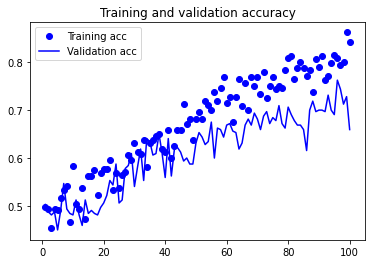

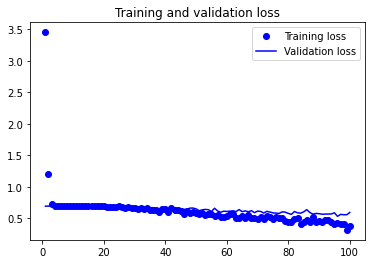

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Comentário: A acurácia no conjunto de teste cresceu até o nível de mais de 85% no conjunto de treino. No entanto, essa acurácia não foi acompanha pela avaliação no conjunto de teste. Isso indica que o modelo está sofrendo com superajuste!

# 2 - Modelo com Transfer Learning

#### MobileNetV2 apresenta uma nova camada CNN, a camada de gargalo linear e residual invertida, permitindo alta precisão / desempenho em aplicações de visão móvel e embarcada. A nova camada se baseia nas convoluções separáveis em profundidade introduzidas no MobileNetV1 [1]. A rede MobileNetV2 é construída em torno dessa nova camada e pode ser adaptada para realizar a classificação e detecção de objetos e segmentação semântica.

#### Convoluções separáveis em profundidade: As convoluções separáveis em profundidade foram introduzidas no MobileNetV1 e são um tipo de convolução fatorada que reduz o custo computacional em comparação com as convoluções padrão. A nova camada MobileNetV2 incorpora convoluções separáveis em profundidade, por isso vale a pena revê-las.

#### Camada de gargalo residual e linear invertida: A premissa da camada residual invertida é que a) mapas de características podem ser codificados em subespaços de baixa dimensão eb) ativações não lineares resultam em perda de informações, apesar de sua capacidade de aumentar a complexidade representacional. Esses princípios orientam o design da nova camada convolucional.

#### Como ponto de partida foi utlizada a arquitetura da rede mobilenetV2, com pesos treinados sobre o conjunto ImageNet [1] e [2]. A camada densa, responsável pela classificação das 1000 categorias da Imagenet, não foi incluída na importação e o formato das imagens input foram alterados para 160x160x3.

In [48]:
mobile = keras.applications.MobileNetV2(weights='imagenet',include_top=False,input_shape=(160, 160, 3))

#### A rede MobileNetV2 possui 2.257.984 parâmetros. Todos esses parâmetros serão mantidos fixos (Não treináveis). Apenas a camada de saída será treinado para o conjunto de dados específico deste projeto.

In [49]:
mobile.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

#### Alterar os parâmetros para não treináveis:

In [50]:
for layer in mobile.layers:
    layer.trainable=False

In [51]:
mobile.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

#### Criar modelo sequencial com adição das camadas GlobalAveragePooling2D e Densa sobre a rede MobileNetV2

In [53]:
model = keras.models.Sequential()
model.add(mobile)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(2, activation='softmax'))

In [54]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Treinar o modelo

#### A função de perda escolhda foi a binary_crossentropy. A métrica de otimização escolhida foi a Acurácia e o otimizador foi o ADAM

In [55]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [56]:
history = model.fit(
train_generator,
steps_per_epoch=10,
epochs=100,
validation_data=validation_generator,
validation_steps=10
)

Epoch 1/100
10/10 [==============================] - 16s 2s/step - loss: 0.5982 - accuracy: 0.7336 - val_loss: 0.3537 - val_accuracy: 0.8562
Epoch 2/100
10/10 [==============================] - 15s 2s/step - loss: 0.2274 - accuracy: 0.9187 - val_loss: 0.1864 - val_accuracy: 0.9344
Epoch 3/100
10/10 [==============================] - 15s 2s/step - loss: 0.1309 - accuracy: 0.9438 - val_loss: 0.1649 - val_accuracy: 0.9469
Epoch 4/100
10/10 [==============================] - 15s 2s/step - loss: 0.0897 - accuracy: 0.9781 - val_loss: 0.1277 - val_accuracy: 0.9531
Epoch 5/100
10/10 [==============================] - 15s 1s/step - loss: 0.1287 - accuracy: 0.9500 - val_loss: 0.1432 - val_accuracy: 0.9344
Epoch 6/100
10/10 [==============================] - 15s 2s/step - loss: 0.0901 - accuracy: 0.9688 - val_loss: 0.1064 - val_accuracy: 0.9625
Epoch 7/100
10/10 [==============================] - 15s 2s/step - loss: 0.0702 - accuracy: 0.9781 - val_loss: 0.0827 - val_accuracy: 0.9594
Epoch 8/100
1

Epoch 59/100
10/10 [==============================] - 15s 2s/step - loss: 0.0177 - accuracy: 0.9937 - val_loss: 0.1091 - val_accuracy: 0.9469
Epoch 60/100
10/10 [==============================] - 15s 2s/step - loss: 0.0193 - accuracy: 0.9969 - val_loss: 0.0785 - val_accuracy: 0.9656
Epoch 61/100
10/10 [==============================] - 15s 2s/step - loss: 0.0140 - accuracy: 0.9969 - val_loss: 0.0718 - val_accuracy: 0.9750
Epoch 62/100
10/10 [==============================] - 15s 2s/step - loss: 0.0138 - accuracy: 0.9969 - val_loss: 0.0830 - val_accuracy: 0.9656
Epoch 63/100
10/10 [==============================] - 15s 2s/step - loss: 0.0161 - accuracy: 0.9969 - val_loss: 0.0798 - val_accuracy: 0.9594
Epoch 64/100
10/10 [==============================] - 15s 2s/step - loss: 0.0158 - accuracy: 0.9969 - val_loss: 0.0781 - val_accuracy: 0.9656
Epoch 65/100
10/10 [==============================] - 15s 2s/step - loss: 0.0200 - accuracy: 0.9969 - val_loss: 0.1202 - val_accuracy: 0.9438
Epoch 

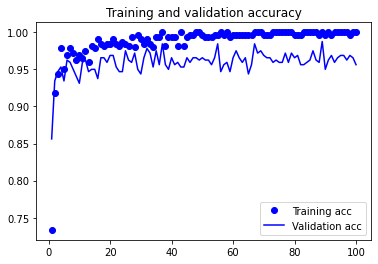

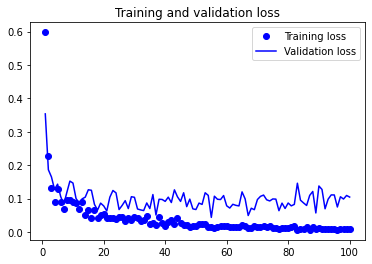

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Resultados:

### O modelo Cold Start conseguiu 65% de acurácia no conjunto de teste. No entanto, percebe-se que a acurácia no conjunto de treino foi 84%, o que mostra problemas na generalização.

### Já o modelo que utilizou transfer learning, atingiu 95.6% de acurácia no conjunto de teste. Isso demonstra a grande contribuição de transfer learnng para o problema em questão.

## Referências

#### [1] A. Howard, “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications,” 2017
#### [2] M. Sandler, “MobileNetV2: Inverted Residuals and Linear Bottlenecks,” 2018